In [1]:
import pandas as pd
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# SA

In [2]:
# preparación de los datos
df = pd.read_csv(filepath_or_buffer = "./diabetes_indiana.csv", sep=',', low_memory=False)
df.describe()


,Unnamed: 0,0,1,2,3,4,5,6,7,8
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,383.500000,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,221.846794,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,191.750000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,383.500000,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,575.250000,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,767.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8
0,0,6,148,72,35,0,33.6,0.627,50,1
1,1,1,85,66,29,0,26.6,0.351,31,0
2,2,8,183,64,0,0,23.3,0.672,32,1
3,3,1,89,66,23,94,28.1,0.167,21,0
4,4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
X, y = df.values[:, :-1], df.values[:, -1]
print(X.shape, y.shape)

(768, 9) (768,)


In [5]:
# separación de los datos en train y test, 80% y 20% respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


modelo = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [6]:
# Evaluación del modelo
y_pred = modelo.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7987012987012987


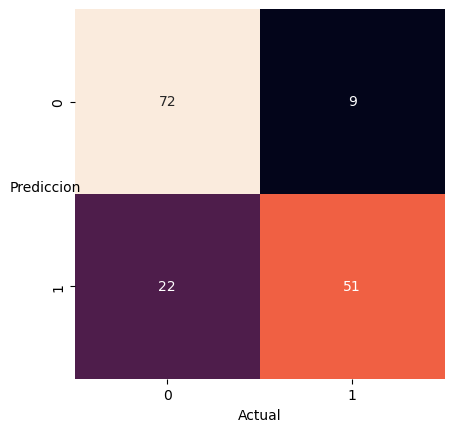

In [7]:
# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual')
plt.ylabel('Prediccion', rotation=0)
plt.show()


In [8]:
# Reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82        94
         1.0       0.70      0.85      0.77        60

    accuracy                           0.80       154
   macro avg       0.79      0.81      0.79       154
weighted avg       0.81      0.80      0.80       154



In [9]:
# Implementación de escalador, por uso general y estandarizado para mejorar la predicción de los datos. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)
#crear modelo
modelo_sc = LogisticRegression(random_state=42, class_weight='balanced')
modelo_sc.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [10]:
# Evaluación del modelo
y_pred_sc = modelo_sc.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_sc))

0.7987012987012987


In [11]:
# Matriz de confusión con los datos escalados
print(classification_report(y_test, y_pred_sc)) 

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82        94
         1.0       0.70      0.85      0.77        60

    accuracy                           0.80       154
   macro avg       0.79      0.81      0.79       154
weighted avg       0.81      0.80      0.80       154



In [12]:
# Afinación de hiperparámetros con random search
# definir el espacio de búsqueda
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)
space['max_iter'] = [100, 1000, 10000]
space['class_weight'] = ['balanced', None]

# definir el procedimiento de búsqueda
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
search = RandomizedSearchCV(estimator=modelo, param_distributions=space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# ejecutar la búsqueda
result = search.fit(X_train_scaled, y_train)

# resumir el mejor resultado
print('Mejor Puntuación: %s' % result.best_score_)
print('Mejores Parámetros: %s' % result.best_params_)

 # Evaluar modelo con los parámetros encontrados
modelo = LogisticRegression(**result.best_params_)
modelo.fit(X_train_scaled, y_train)

# Evaluación del modelo
y_pred_optimizado = modelo.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_optimizado))

Mejor Puntuación: 0.7693812797461662
Mejores Parámetros: {'C': 0.07880836497637313, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7792207792207793


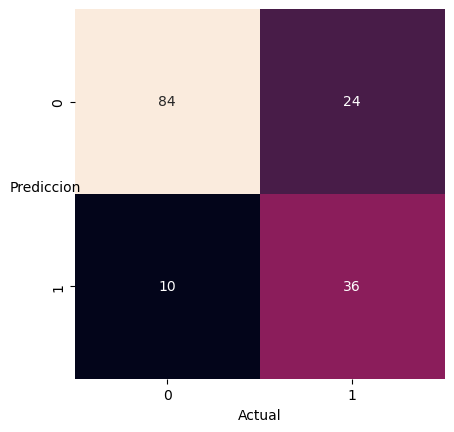

In [13]:
# Matriz de confusión optimizada
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_pred_optimizado)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual')
plt.ylabel('Prediccion', rotation=0)
plt.show()


In [14]:
# Reporte de clasificación
print(classification_report(y_test, y_pred_optimizado))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83        94
         1.0       0.78      0.60      0.68        60

    accuracy                           0.78       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.78      0.78      0.77       154



In [15]:
print("El modelo optimizado es mejor que el modelo sin optimizar, ya que la precisión es mayor en el modelo optimizado")

El modelo optimizado es mejor que el modelo sin optimizar, ya que la precisión es mayor en el modelo optimizado


In [16]:
#shape de los datos
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape)

(614, 9) (614,) (154, 9) (154,)
(614, 9) (614,) (154, 9) (154,)


In [17]:
X_train[:,1]

array([ 2.,  0.,  6.,  1.,  6.,  8.,  6.,  7.,  5.,  3.,  4.,  0.,  3.,
        7.,  9.,  1., 11.,  0.,  1.,  7.,  2.,  4.,  1.,  9.,  8.,  0.,
        1.,  0.,  8.,  4.,  2., 17.,  3.,  2.,  0.,  1.,  0.,  4.,  0.,
        1.,  2.,  0.,  1.,  4.,  0.,  1.,  0.,  1.,  2.,  1.,  2.,  1.,
        0.,  1.,  6.,  0.,  1.,  4.,  2.,  1., 13.,  1.,  3.,  1., 10.,
        0.,  1.,  0.,  6.,  2.,  6.,  1.,  3., 10.,  2.,  3.,  6.,  1.,
        0.,  4.,  2.,  3.,  3.,  0.,  3.,  1., 13.,  5.,  2.,  6.,  3.,
        1.,  0.,  2.,  5.,  4.,  0.,  5.,  4.,  2.,  1.,  1.,  3.,  2.,
        1.,  9.,  0., 12.,  5.,  0.,  1.,  7.,  2.,  0.,  2.,  1.,  3.,
        3.,  7.,  5.,  1.,  7.,  6.,  3.,  2.,  3.,  0.,  1.,  0.,  2.,
        4.,  4.,  5.,  1.,  0.,  7.,  3., 13.,  9.,  8.,  1.,  3.,  0.,
        0.,  1.,  0.,  1.,  5.,  1.,  0.,  2.,  1.,  2.,  8., 10.,  3.,
        3.,  3.,  6.,  8.,  6.,  0.,  5.,  2.,  1.,  2.,  0.,  1.,  0.,
        0.,  0.,  6.,  2.,  0.,  6.,  8.,  4.,  9.,  1.,  4.,  6

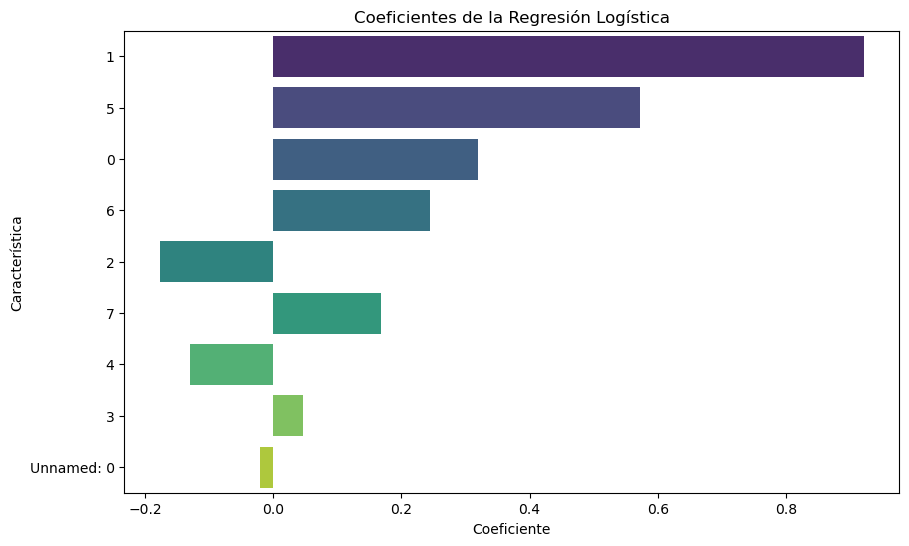

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression



# Obtener los coeficientes y nombres de características
coeficientes = modelo.coef_[0]
nombres_caracteristicas = df.columns[:-1]

# Crear un DataFrame para visualizar
coef_df = pd.DataFrame({'Característica': nombres_caracteristicas, 'Coeficiente': coeficientes})

# Ordenar por valor absoluto de coeficientes
coef_df = coef_df.reindex(coef_df['Coeficiente'].abs().sort_values(ascending=False).index)

# Graficar los coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Característica', data=coef_df, palette='viridis')
plt.title('Coeficientes de la Regresión Logística')
plt.show()

In [19]:
# explicacion de grafica de coeficientes
# entre mayor longitud de la barra, mayor importancia tiene la caracteristica en la prediccion del modelo
# entre mas cercano a cero, menos importancia tiene la caracteristica en la prediccion del modelo

# DE

In [3]:
# usando otro algoritmo de clasificacion
import pandas as pd
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv(filepath_or_buffer = "./diabetes_indiana.csv", sep=',', low_memory=False)
X, y = df.values[:, :-1], df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [6]:
# crear modelo
modelo_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# entrenar modelo
modelo_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

0.7402597402597403


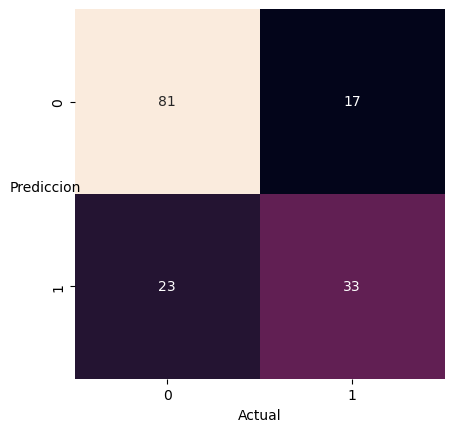

In [7]:
# evaluar modelo
y_pred_rf = modelo_rf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_rf))

# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual')
plt.ylabel('Prediccion', rotation=0)
plt.show()

In [8]:
# Reporte de clasificación
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       104
         1.0       0.59      0.66      0.62        50

    accuracy                           0.74       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.75      0.74      0.74       154



In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el espacio de búsqueda
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(randint(5, 50).rvs(5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

# Create a random search object
randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1  # Use parallel processing
)

# Entrene el modelo en los datos de entrenamiento escalados
randomized_search.fit(X_train_scaled, y_train)

print("Best Parameters:", randomized_search.best_params_)

# Usar el mejor modelo
best_model = randomized_search.best_estimator_


Best Parameters: {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 27}


0.7207792207792207


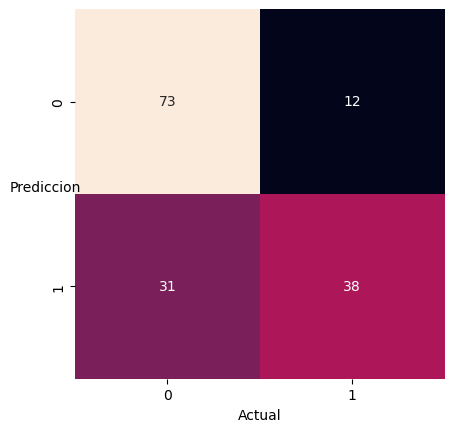

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77       104
         1.0       0.55      0.76      0.64        50

    accuracy                           0.72       154
   macro avg       0.70      0.73      0.71       154
weighted avg       0.76      0.72      0.73       154



In [10]:
# Evaluar modelo
y_pred_best = best_model.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_best))

# Matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_pred_best)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual')
plt.ylabel('Prediccion', rotation=0)
plt.show()


# Reporte de clasificación
print(classification_report(y_test, y_pred_best))
